# Energy Case Study — Data Prep & EDA

This notebook loads the Excel sheets, upscales/aligns them to hourly data, merges,
does light cleaning, then explores distributions and time series before exporting a clean CSV.

## Imports

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-colorblind')

## Helpers

### Datetime upscaling/scaffolding

In [2]:
def upscale_datetimes(
    df: pd.DataFrame,
    *,
    date_col: str,
    date_format: str | None = None,
    drop_cols: list[str] | None = None,
    start: str | pd.Timestamp = "2022-01-01 00:00",
    end: str | pd.Timestamp = "2024-06-12 23:00",
) -> pd.DataFrame:
    """
    Parse df[date_col] to datetime (using date_format if given), rename to 'Date (UTC)',
    align to an hourly index from start..end, and ffill/bfill gaps.
    Returns a DataFrame indexed by a DatetimeIndex named 'Date (UTC)'.
    """
    df = df.copy()

    # 1) Parse the date column
    if date_format:
        dt = pd.to_datetime(df[date_col], format=date_format, errors="coerce")
    else:
        dt = pd.to_datetime(df[date_col], errors="coerce", utc=False)

    # 2) Rename to 'Date (UTC)' and set index
    df = df.drop(columns=[date_col]).assign(**{"Date (UTC)": dt}).set_index("Date (UTC)")

    # 3) Optionally drop columns
    if drop_cols:
        # keep only columns that exist
        drop_cols = [c for c in drop_cols if c in df.columns]
        if drop_cols:
            df = df.drop(columns=drop_cols)

    # 4) Build the hourly scaffold and align
    hourly_index = pd.date_range(start=pd.Timestamp(start), end=pd.Timestamp(end), freq="h", name="Date (UTC)")
    # Reindex then ffill/bfill to upsample daily/monthly/irregular to hourly
    df = df.sort_index().reindex(hourly_index).ffill().bfill()

    return df


### Distribution plots (hist + KDE)

In [3]:
def plot_group(cols, color, title):
    if not cols:
        return
    n = len(cols)
    ncols = 3 if n >= 7 else 2
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 3.8*nrows))
    axes = np.array(axes).reshape(-1)  # flatten even if single row
    for ax, col in zip(axes, cols):
        sns.histplot(df[col].dropna(), kde=True, stat="density", bins="auto", color=color, ax=ax)
        ax.set_title(col, fontsize=10)
        ax.set_xlabel("")
        ax.set_ylabel("Density")
    # hide any unused axes
    for ax in axes[len(cols):]:
        ax.set_visible(False)
    fig.suptitle(title, fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()


### Time-series panel plots

In [4]:
def plot_group_timeseries(
    df,
    cols,
    color="C0",
    title="",
    resample="D",
    date_candidates=("Date (UTC)", "date (utc)", "date_utc", "date", "datetime", "timestamp"),
):
    import matplotlib.dates as mdates
    
    if not cols:
        return

    df_work = df.copy()

    # Detect / set datetime index
    if isinstance(df_work.index, pd.DatetimeIndex):
        dt_name = df_work.index.name or "Date (UTC)"
    else:
        norm = {c: c.lower().replace(" ", "_") for c in df_work.columns}
        rev = {v: k for k, v in norm.items()}
        found = None
        for cand in date_candidates:
            key = cand.lower().replace(" ", "_")
            if key in rev:
                found = rev[key]
                break
        if found is None:
            dt_cols = [c for c in df_work.columns if pd.api.types.is_datetime64_any_dtype(df_work[c])]
            if dt_cols:
                found = dt_cols[0]
            else:
                raise KeyError("Could not find a datetime column or DatetimeIndex in the provided DataFrame.")

        dt_name = found
        df_work[dt_name] = pd.to_datetime(df_work[dt_name], errors="coerce")
        df_work = df_work.set_index(dt_name)

    # Keep only requested columns that exist
    cols_present = [c for c in cols if c in df_work.columns]
    if not cols_present:
        print("No requested columns found in DataFrame.")
        return
    if len(cols_present) < len(cols):
        missing = sorted(set(cols) - set(cols_present))
        print(f"Skipping missing columns: {missing}")

    df_plot = df_work[cols_present].sort_index()

    # Optional resampling
    if resample:
        df_plot = df_plot.resample(resample).mean(numeric_only=True)

    # Reset index so seaborn can use a named datetime column
    df_plot = df_plot.reset_index().rename(columns={"index": dt_name})

    # Layout
    n = len(cols_present)
    ncols = 3 if n >= 7 else 2
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 3.5 * nrows), sharex=False)
    axes = np.array(axes).reshape(-1)

    # Date tick formatter & locator
    date_fmt = mdates.DateFormatter("%m-%y")  
    date_loc = mdates.AutoDateLocator(minticks=5, maxticks=10)

    # Plot each series
    for ax, col in zip(axes, cols_present):
        sns.lineplot(data=df_plot, x=dt_name, y=col, ax=ax, color=color)
        ax.set_title(col, fontsize=10)
        ax.set_xlabel("")
        ax.grid(True, alpha=0.3)

        # Apply formatter/locator + rotate labels
        ax.xaxis.set_major_locator(date_loc)
        ax.xaxis.set_major_formatter(date_fmt)
        ax.tick_params(axis="x", labelrotation=45)
        for lbl in ax.get_xticklabels():
            lbl.set_horizontalalignment("right")

    # Hide unused axes
    for ax in axes[len(cols_present):]:
        ax.set_visible(False)

    fig.suptitle(title, fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()


## Input: open the Excel workbook

In [5]:
xls = pd.ExcelFile("Case Study Data .xlsx")
df_genmix = upscale_datetimes(
    pd.read_excel(xls, sheet_name="Generation Mix"),
    date_col="Date (UTC)")
    
df_prices = upscale_datetimes(
    pd.read_excel(xls, sheet_name="Day-ahead Prices"),
    date_col="Date (UTC)")

df_load = upscale_datetimes(
    pd.read_excel(xls, sheet_name="Load"),
    date_col="Date (UTC)")

df_tb = upscale_datetimes(
    pd.read_excel(xls, sheet_name="Import_Export"),
    date_col="Date (UTC)")

df_co2_filled = upscale_datetimes(
    pd.read_excel(xls, sheet_name="CO2 Prices"),
    date_col="Date",
    date_format="%d.%m.%Y")

df_gas_filled = upscale_datetimes(
    pd.read_excel(xls, sheet_name="Natural Gas Prices"),
    date_col="Date",
    date_format="%m/%d/%Y",
    drop_cols=["Price PLN/MWh", "Date"])

df_coal_filled = upscale_datetimes(
    pd.read_excel(xls, sheet_name="Coal Prices"),
    date_col="Date",
    date_format="%Y-%m-%d")

df_capacities_filled = upscale_datetimes(
    pd.read_excel(xls, sheet_name="Installed Solar Wind Capacity"),
    date_col="Month",
    date_format="%Y-%m-%d")

## Merge and Clean

In [6]:
df = (
    df_genmix
    .join(df_prices, how="outer")
    .join(df_load, how="outer")
    .join(df_tb, how="outer")
    .join(df_co2_filled, how="outer")
    .join(df_gas_filled, how="outer")
    .join(df_coal_filled, how="outer")
    .join(df_capacities_filled, how="outer")
)

df = df.rename(columns={
    "Amount":"Trade Balance",
    "Price EUR/MWh": "Natural Gas EUR/MWh",
    "Price per ton CO2": "CO2 EUR/ton",
    "Price EUR per T": "Coal EUR/ton"
})
mask_export = (
    df["Export / Import (Daily)"]
    .astype("string").str.strip().str.lower().eq("export")
)
df.loc[mask_export, "Trade Balance"] *= -1
df.drop(columns=["Export / Import (Daily)"], inplace=True, errors="ignore")
df.columns = df.columns.str.lower().str.replace(" ", "_").str.replace("-", "_")

## Plots

### Groups for plotting

In [7]:
num_cols = df.select_dtypes(include="number").columns.tolist()

# Group 1: quantities (Generation Mix)
gen_order = ["biomass","brown_coal/lignite","coal_derived_gas","natural_gas","hard_coal",
             "oil","hydro_pumped_storage","hydro_run_of_river","hydro_water_reservoir",
             "solar","wind"]
group1 = [c for c in gen_order if c in num_cols]

# Group 2: EUR prices
group2 = [c for c in ["day_ahead_price_eur","natural_gas_eur/mwh","co2_eur/ton","coal_eur/ton"] if c in num_cols]

# Group 3: everything else numeric
group3 = [c for c in num_cols if c not in set(group1 + group2)]

### Histograms

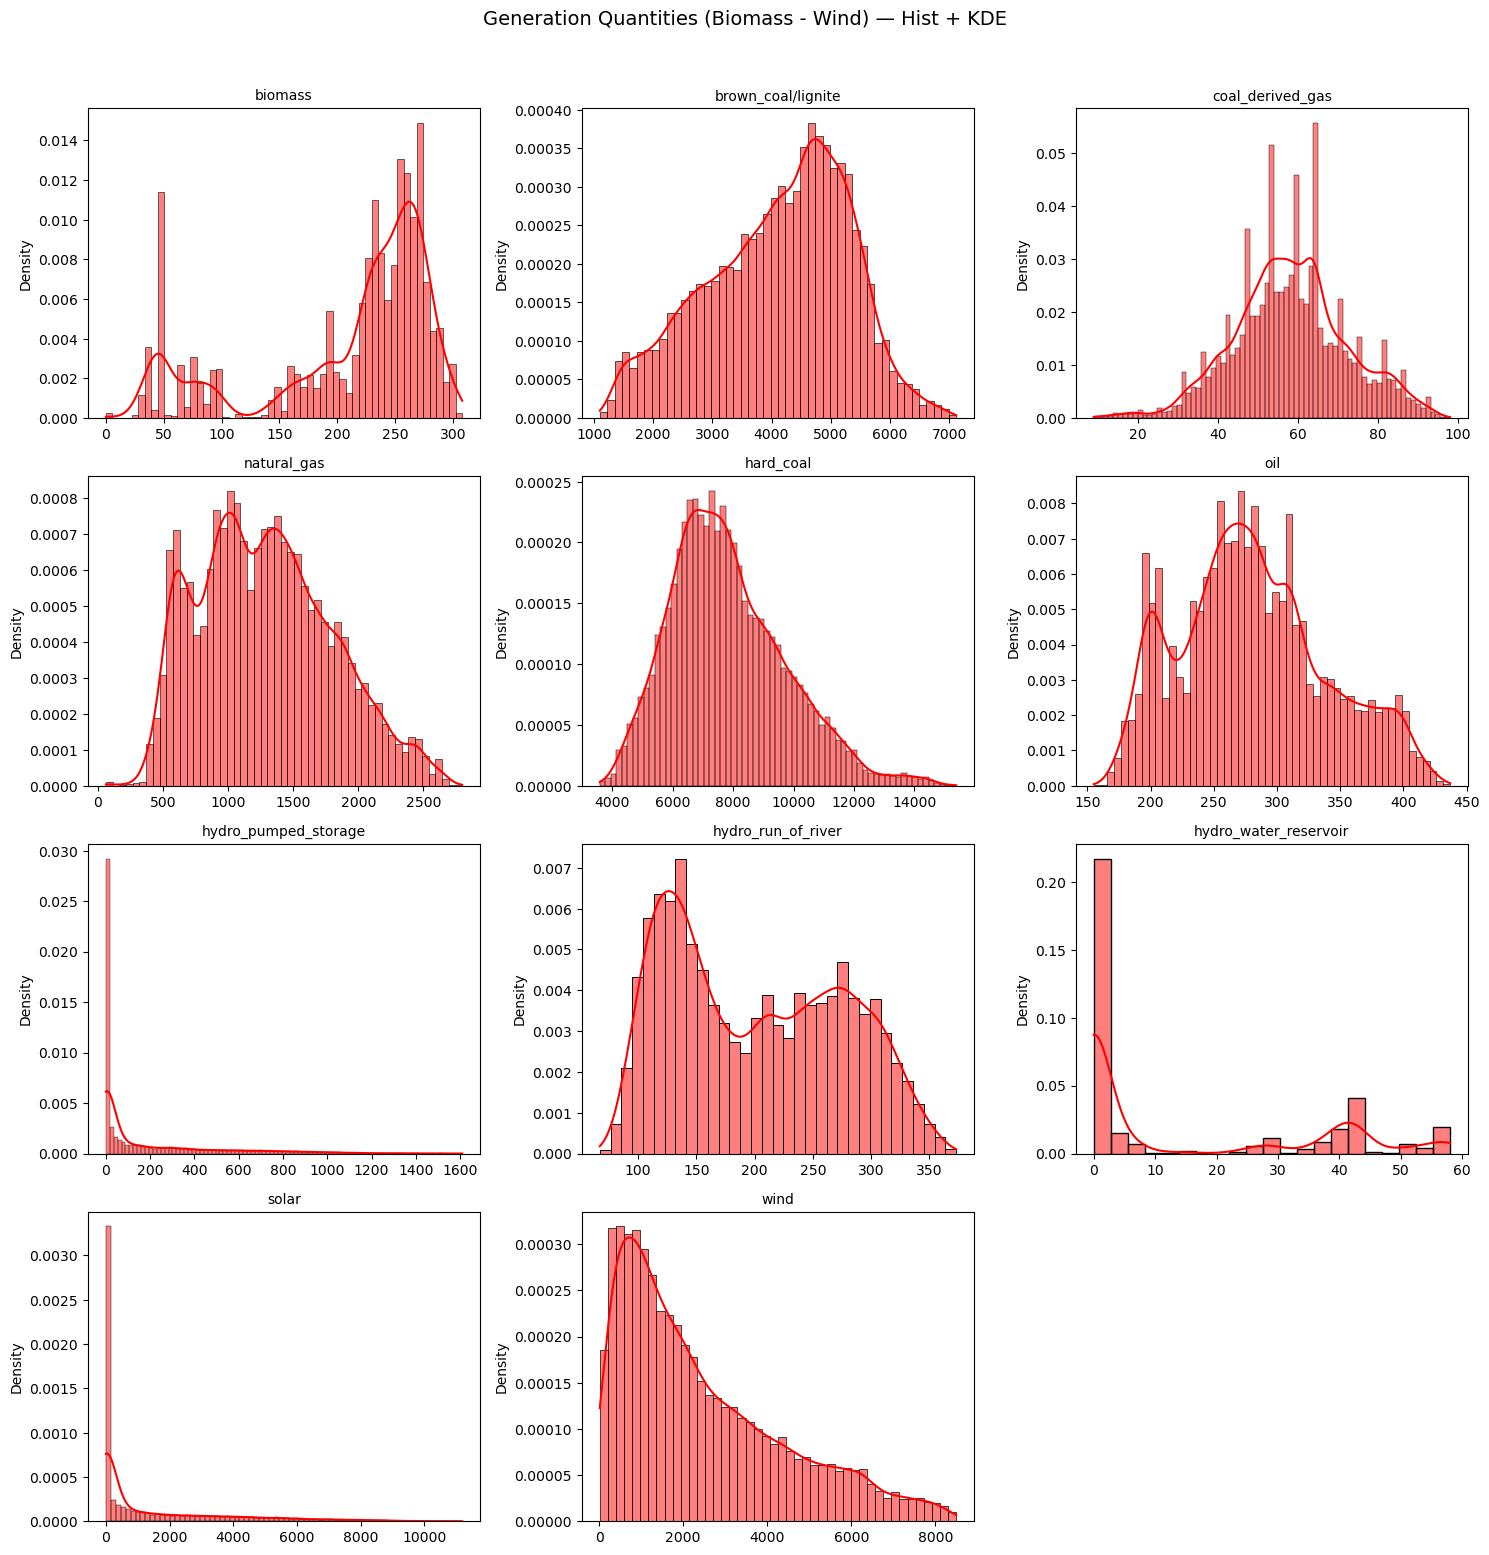

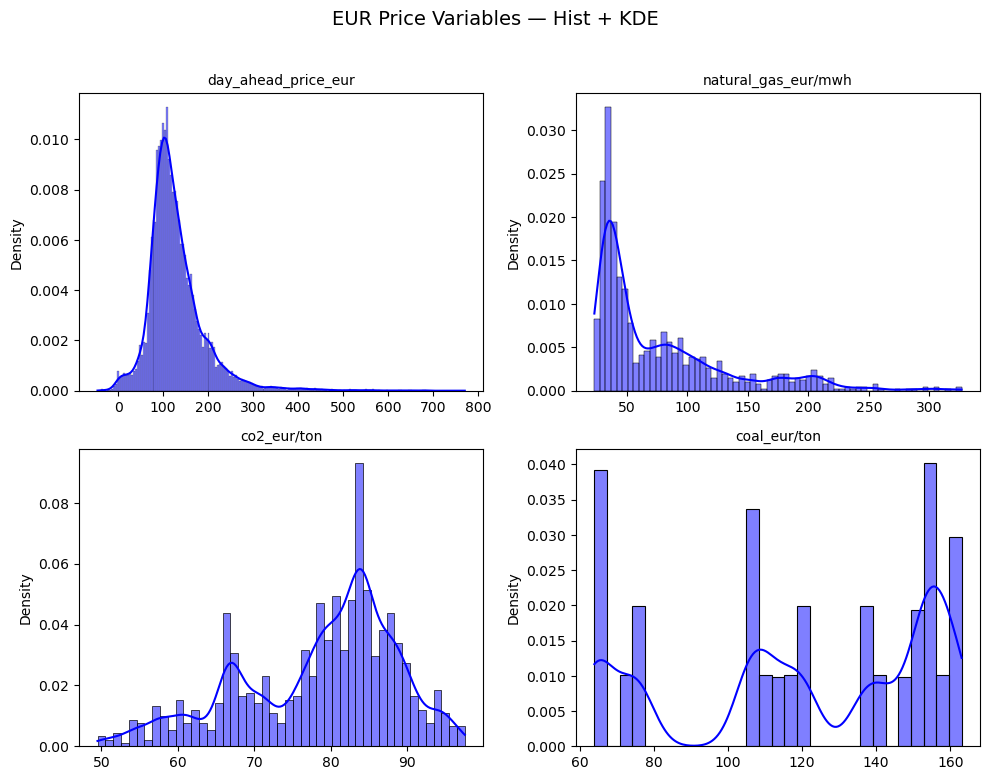

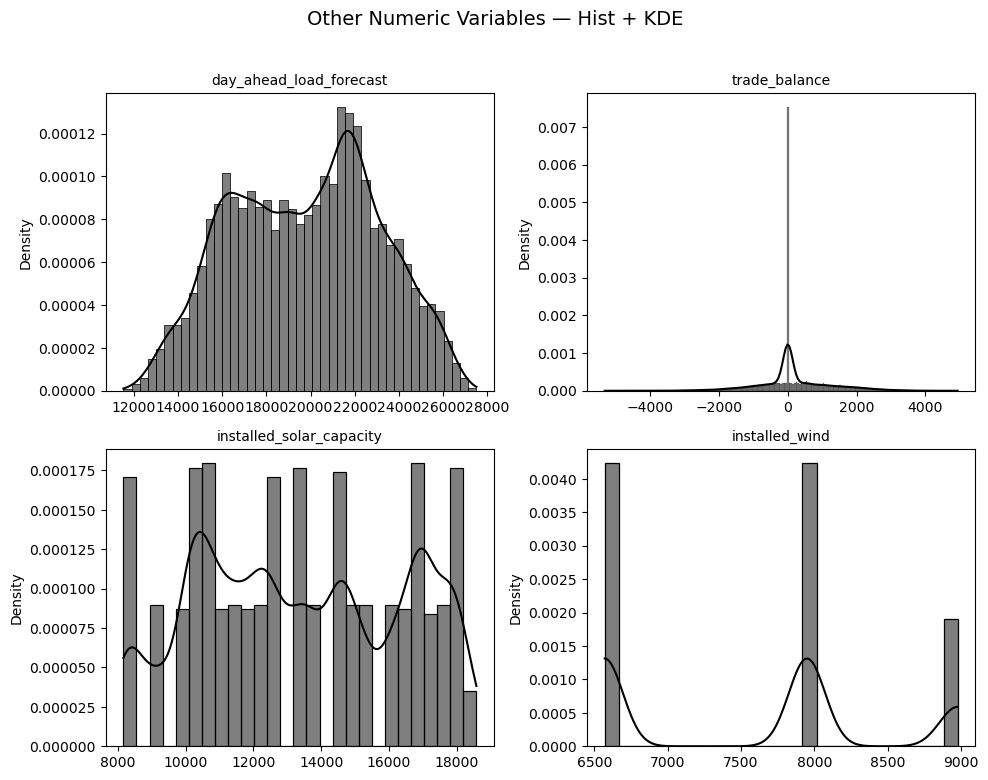

In [8]:
plot_group(group1, color="red",  title="Generation Quantities (Biomass - Wind) — Hist + KDE")
plot_group(group2, color="blue", title="EUR Price Variables — Hist + KDE")
plot_group(group3, color="black", title="Other Numeric Variables — Hist + KDE")

### Timeseries

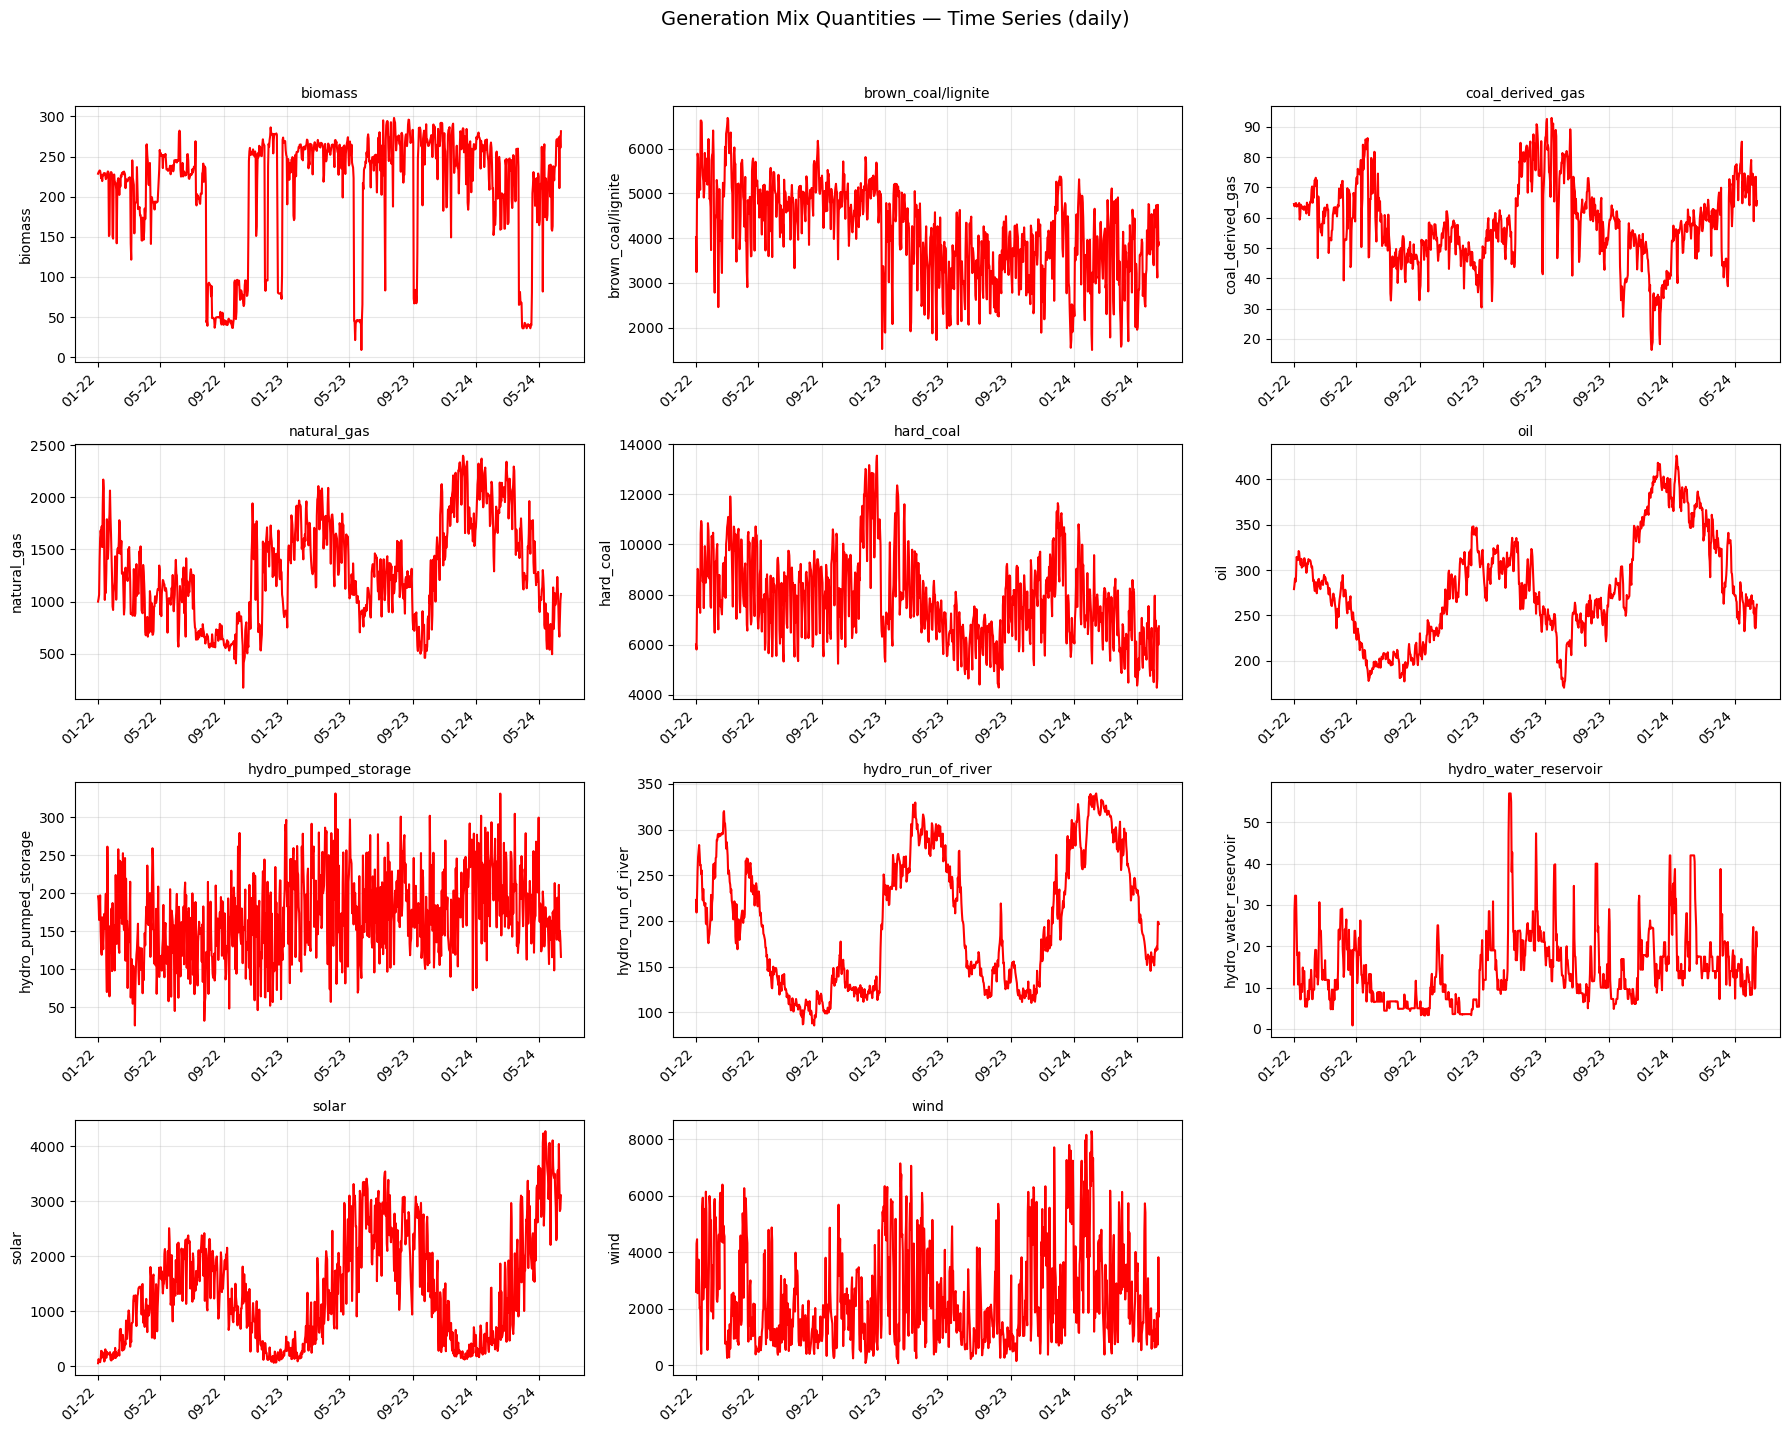

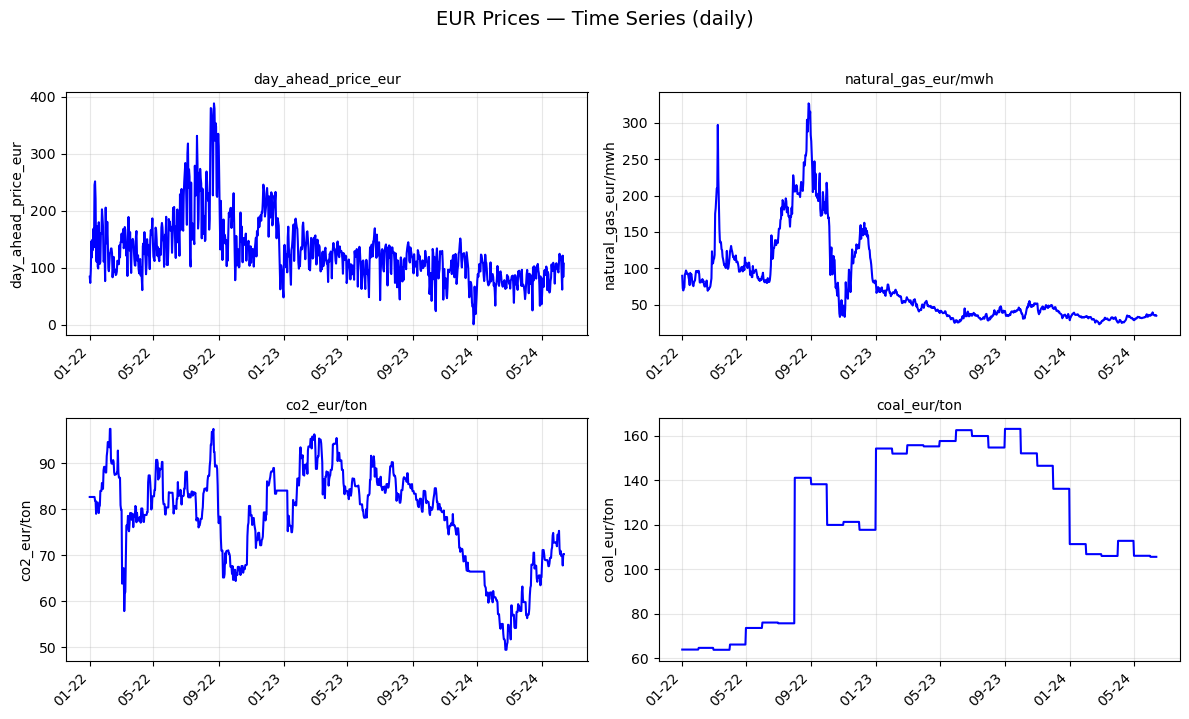

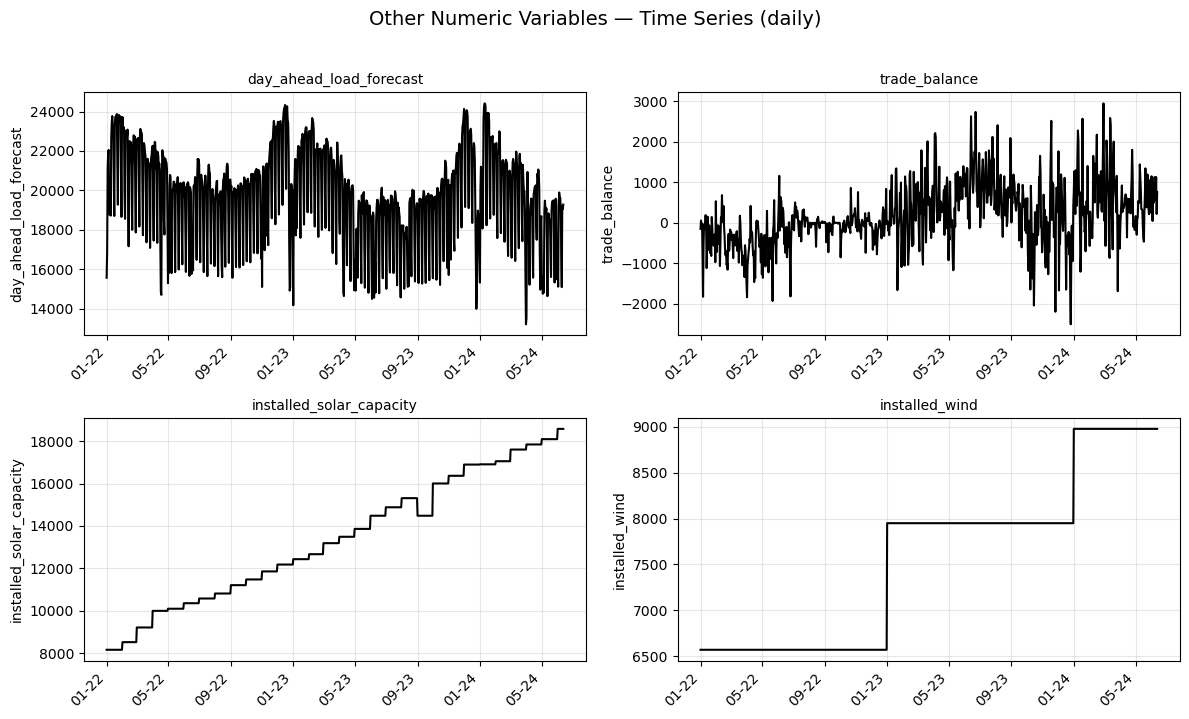

In [9]:
plot_group_timeseries(df, group1, color="red",  title="Generation Mix Quantities — Time Series (daily)", resample="D")
plot_group_timeseries(df, group2, color="blue", title="EUR Prices — Time Series (daily)", resample="D")
plot_group_timeseries(df, group3, color="black", title="Other Numeric Variables — Time Series (daily)", resample="D")

## Export

In [10]:
df.reset_index(inplace=True)
df.rename(columns={"Date (UTC)":"datetime"}, inplace=True)
df["datetime"] = pd.to_datetime(df["datetime"])
df.to_csv("clean_data.csv", index=False)